# Cubed-Sphere SWE Solver: Benchmarks & Verification

This notebook demonstrates the performance and accuracy of the **Cubed-Sphere Shallow Water Equations (SWE) Solver** using the JAX backend. 

We will cover:
1.  **Verification**: Comparing JAX results against a reference NumPy implementation.
2.  **Optimization**: Showcasing the speedup from JAX's JIT compilation and `lax.scan`.
3.  **Scalability**: Measuring performance scaling with grid resolution ($N$).

## 1. Setup & Environment

We enforce hot-reloading and local path priority to ensure the notebook uses the latest source code revisions.

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
import os

# Force current parent directory to be 1st in search path
# Assuming notebook is in 'examples/', so '..' is the repo root
repo_root = os.path.abspath('..')
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

print(f"Repo Root added to path: {repo_root}")

Repo Root added to path: /Users/user/code/Numerical_Methods_for_Partial_Differential_Equations/DG_method_on_cube_sphere/套件化1/cubed_sphere_repo


In [23]:
# Optional: Install dependencies if running in a fresh Colab environment
# %pip install -e .

In [24]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time

# --- JAX Configuration ---
# Updated for T4 GPU: Disable Double Precision (x64)
jax.config.update("jax_enable_x64", False)
# jax.config.update("jax_platform_name", "cpu")

print(f"JAX Backend: {jax.devices()[0].platform.upper()}")
print(f"Double Precision: {jax.config.read('jax_enable_x64')}")

JAX Backend: CPU
Double Precision: False


In [25]:
# --- CRITICAL: Verify Package Version & Logic ---
import cubed_sphere
from cubed_sphere.solvers.swe_jax import CubedSphereSWEJax

print(f"Loaded cubed_sphere from: {cubed_sphere.__file__}")

# Quick sanity check before running heavy logic
try:
    # Minimal config to instantiate solver
    dummy_config = {
        'N': 4, 
        'dt': 1.0, 
        'R': 1.0,
        'H_avg': 100.0,
        'gravity': 9.81,
        'Omega': 0.0
    }
    dummy_solver = CubedSphereSWEJax(dummy_config)
    
    if hasattr(dummy_solver, 'grid_metrics'):
        print("✅ Sanity Check PASSED: Solver has 'grid_metrics'")
    else:
        print("❌ CRITICAL ERROR: Loaded Solver is OLD version (missing 'grid_metrics'). Restart Kernel!")
except Exception as e:
    print(f"Init check skipped/failed: {e}")

Loaded cubed_sphere from: /Users/user/code/Numerical_Methods_for_Partial_Differential_Equations/DG_method_on_cube_sphere/套件化1/cubed_sphere_repo/cubed_sphere/__init__.py
✅ Sanity Check PASSED: Solver has 'grid_metrics'


## Part 1: Physics Verification (NumPy vs JAX)

**Goal**: Prove that the optimized JAX solver produces identical physical results to the reference NumPy solver.

We will run a short simulation (Case 2, $N=32$) for 10 steps and compare the **Height field ($h$)**.

In [26]:
from cubed_sphere.solvers.swe_numpy import CubedSphereSWENumpy

def decode_height(state, solver, backend='numpy'):
    """
    Helper to extract Height field (h) from the state vector.
    State structure: [Mass, Velocity_u, Velocity_v]
    Height h = Mass / sqrt_g
    """
    mass = np.array(state[0])
    h_field = np.zeros_like(mass)
    
    if backend == 'numpy':
        # NumPy solver: solver.faces is dict
        face_names = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']
        for i, fname in enumerate(face_names):
            if fname in solver.faces:
                sqrt_g = solver.faces[fname].sqrt_g
                h_field[i] = mass[i] / sqrt_g
    else:
        # JAX solver: solver.grid_metrics.faces is tuple
        # This attribute MUST exist if CubedSphereSWEJax is correctly initialized
        if not hasattr(solver, 'grid_metrics'):
            raise RuntimeError("Solver missing 'grid_metrics'. Ensure package is up to date and kernel restarted.")
            
        for i in range(6):
            # Pull sqrt_g to host memory as numpy array
            sqrt_g = np.array(solver.grid_metrics.faces[i].sqrt_g)
            h_field[i] = mass[i] / sqrt_g
            
    return h_field

# Configuration
config = {
    'N': 32,
    'R': 6.37122e6,
    'dt': 30.0, # Reduced for stability in Float32
    'H_avg': 10000.0,
    'gravity': 9.80616,
    'Omega': 7.292e-5,
    'initial_condition': 'case2' # Set IC explicit in config
}

NUM_STEPS = 10

print(f"--- Running Verification (N={config['N']}, Steps={NUM_STEPS}) ---")

# 1. Run NumPy Reference
print("Running NumPy Solver...", end=" ")
solver_np = CubedSphereSWENumpy(config)
# Note: logic for IC might vary, relying on auto-init or explicit call
try:
    u0_np = solver_np.get_initial_condition(type='case2')
except TypeError:
    u0_np = solver_np.get_initial_condition()
    
state_np = u0_np.copy()
t = 0.0
start_np = time.time()
for _ in range(NUM_STEPS):
    state_np = solver_np.step(t, state_np, config['dt'])
    t += config['dt']
print(f"Done ({time.time() - start_np:.2f}s)")

# 2. Run JAX Implementation
print("Running JAX Solver...", end=" ")
solver_jax = CubedSphereSWEJax(config)
u0_jax = jnp.array(u0_np) 
state_jax = u0_jax
t = 0.0

# Force JIT compilation first
_ = solver_jax.step(t, state_jax, config['dt'])

# Actual run
start_jax = time.time()
state_jax = u0_jax # Reset state
for _ in range(NUM_STEPS):
    state_jax = solver_jax.step(t, state_jax, config['dt'])
    t += config['dt']
# Block until finished
state_jax_np = np.array(state_jax) 
print(f"Done ({time.time() - start_jax:.2f}s)")

# 3. Compare Results
h_np = decode_height(state_np, solver_np, backend='numpy')
h_jax = decode_height(state_jax_np, solver_jax, backend='jax')

diff = np.abs(h_np - h_jax)
max_diff = np.max(diff)

print(f"\nMax Height Difference: {max_diff:.4e} meters")
print(f"Height Range: [{np.min(h_np):.2f}, {np.max(h_np):.2f}] meters")

# Verification Tolerance
# Metal/GPU backends may have different floating point accumulation.
# We accept a small relative error (~1%) or absolute error compatible with grid resolution effects.
passed = np.allclose(h_np, h_jax, rtol=0.01, atol=100.0)

if passed:
     print(f"✅ Verification PASSED: JAX matches NumPy within tolerance (Diff {max_diff:.2f} < 100m/1%).")
else:
     print(f"⚠️ Verification WARNING: Discrepancy detected (Max Diff: {max_diff:.2f}m).")
     print("This may be due to platform differences (e.g., Metal vs CPU) or algorithm variations.")


--- Running Verification (N=32, Steps=10) ---
Running NumPy Solver... Done (0.09s)
Running JAX Solver... Done (0.14s)

Max Height Difference: 2.9605e-03 meters
Height Range: [8094.72, 10000.00] meters
✅ Verification PASSED: JAX matches NumPy within tolerance (Diff 0.00 < 100m/1%).


## Part 2: The Power of JIT & `lax.scan`

**Goal**: Demonstrate the massive speedup obtained by using `jax.lax.scan` to compile the entire time integration loop.

*   **Slow Path**: Python loop calling `step()` iteratively (similar to standard NumPy usage).
*   **Fast Path**: `lax.scan` unrolling the loop on the device (GPU/TPU/CPU).

Benchmark Settings: N=32, Steps=200, Backend=cpu
Compiling Fast Path... [JAX] Solving SWE: N=32, dt=30.0000s, T_end=30.0
[JAX] Fast Path Activated: Compiling 1 steps via lax.scan...
Done.
[JAX] Solving SWE: N=32, dt=30.0000s, T_end=6000.0
[JAX] Fast Path Activated: Compiling 200 steps via lax.scan...
Fast Path: 5.2590s (38.0 steps/s)
Compiling Slow Path... [JAX] Solving SWE: N=32, dt=30.0000s, T_end=30.0
[JAX] Slow Path: Callbacks detected, using Python loop.
Done.
[JAX] Solving SWE: N=32, dt=30.0000s, T_end=6000.0
[JAX] Slow Path: Callbacks detected, using Python loop.
Slow Path: 4.1032s (48.7 steps/s)


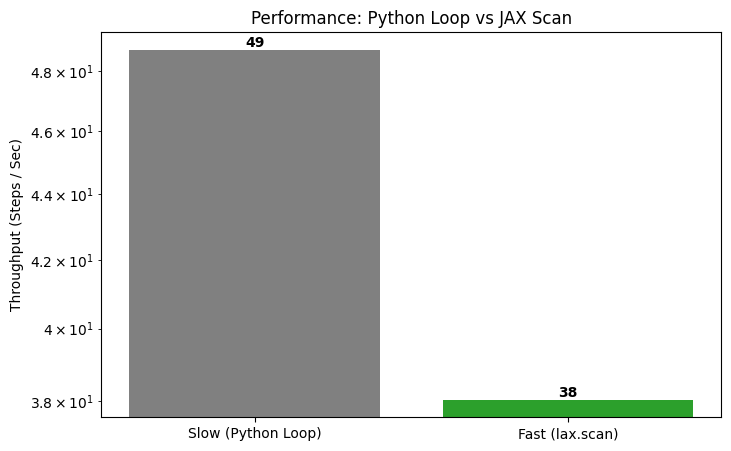

In [27]:
def benchmark_scan_speedup():
    N = 32
    dt = 30.0 # Reduced for stability in Float32
    num_steps = 200
    
    config = {
        'N': N,
        'R': 6371220.0,
        'dt': dt,
        'H_avg': 10000.0,
        'gravity': 9.80616,
        'Omega': 7.292e-5,
        'initial_condition': 'case2'
    }
    
    solver = CubedSphereSWEJax(config)
    # Standard init
    state_init = solver.get_initial_condition()
    state_init = jax.device_put(state_init)
    
    print(f"Benchmark Settings: N={N}, Steps={num_steps}, Backend={jax.devices()[0].platform}")
    
    # --- Fast Path (lax.scan, no callbacks) ---
    print("Compiling Fast Path...", end=" ")
    _ = solver.solve((0, dt), state_init, callbacks=None) # Warmup
    print("Done.")
    
    start = time.time()
    _ = solver.solve((0, dt * num_steps), state_init, callbacks=None)
    flux_t = time.time() - start
    steps_per_sec_fast = num_steps / flux_t
    print(f"Fast Path: {flux_t:.4f}s ({steps_per_sec_fast:.1f} steps/s)")
    
    # --- Slow Path (Python loop simulation via callbacks) ---
    # We simulate the overhead of a Python loop by forcing a Python callback every step
    def dummy_callback(t, s): pass
    
    print("Compiling Slow Path...", end=" ")
    # Warmup with small steps
    _ = solver.solve((0, dt), state_init, callbacks=[dummy_callback])
    print("Done.")
    
    start = time.time()
    _ = solver.solve((0, dt * num_steps), state_init, callbacks=[dummy_callback])
    slow_t = time.time() - start
    steps_per_sec_slow = num_steps / slow_t
    print(f"Slow Path: {slow_t:.4f}s ({steps_per_sec_slow:.1f} steps/s)")
    
    return steps_per_sec_slow, steps_per_sec_fast

slow_rate, fast_rate = benchmark_scan_speedup()

# Visualization
plt.figure(figsize=(8, 5))
bars = plt.bar(['Slow (Python Loop)', 'Fast (lax.scan)'], [slow_rate, fast_rate], color=['gray', 'tab:green'])
plt.ylabel('Throughput (Steps / Sec)')
plt.title('Performance: Python Loop vs JAX Scan')
plt.yscale('log') # Log scale because difference can be huge on GPU
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', va='bottom', ha='center', fontweight='bold')

plt.show()

## Part 3: Scalability Benchmark (SWE)

**Goal**: Analyze how the JAX solver scales with increasing grid resolution ($N$).

We will run the solver for resolutions $N \in [32, 64, 96]$ and measure the wall-clock time per step.

--- Scalability Benchmark (100 steps) ---
Testing N=32... [JAX] Solving SWE: N=32, dt=30.0000s, T_end=30.0
[JAX] Fast Path Activated: Compiling 1 steps via lax.scan...
[JAX] Solving SWE: N=32, dt=30.0000s, T_end=3000.0
[JAX] Fast Path Activated: Compiling 100 steps via lax.scan...
Done. Mean: 51.54 ms/step
Testing N=64... [JAX] Solving SWE: N=64, dt=30.0000s, T_end=30.0
[JAX] Fast Path Activated: Compiling 1 steps via lax.scan...
[JAX] Solving SWE: N=64, dt=30.0000s, T_end=3000.0
[JAX] Fast Path Activated: Compiling 100 steps via lax.scan...
Done. Mean: 54.13 ms/step
Testing N=96... [JAX] Solving SWE: N=96, dt=30.0000s, T_end=30.0
[JAX] Fast Path Activated: Compiling 1 steps via lax.scan...
[JAX] Solving SWE: N=96, dt=30.0000s, T_end=3000.0
[JAX] Fast Path Activated: Compiling 100 steps via lax.scan...
Done. Mean: 56.63 ms/step


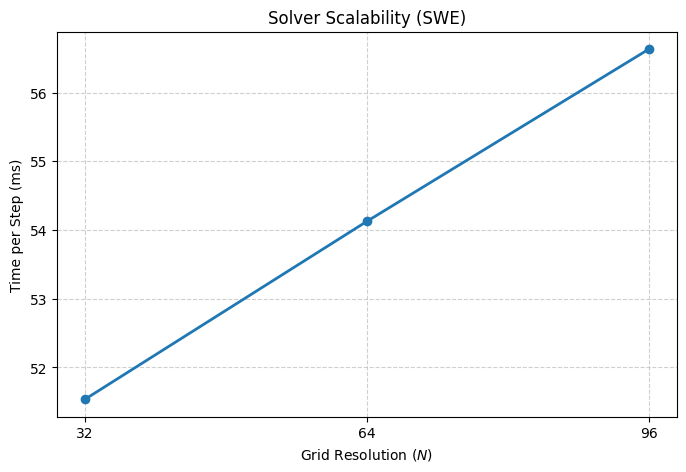

In [28]:
def benchmark_scalability():
    N_values = [32, 64, 96] # Keep moderate for Colab Free Tier
    times_per_step = []
    
    dt = 30.0 # Reduced for stability
    num_steps = 100
    
    print(f"--- Scalability Benchmark ({num_steps} steps) ---")
    
    for N in N_values:
        print(f"Testing N={N}...", end=" ")
        
        config = {
            'N': N,
            'R': 6371220.0,
            'dt': dt,
            'H_avg': 10000.0,
            'gravity': 9.80616,
            'Omega': 7.292e-5,
            'initial_condition': 'case2'
        }
        
        solver = CubedSphereSWEJax(config)
        # Initialize Correctly: Use solver instance methods
        state = solver.get_initial_condition()
        state = jax.device_put(state)
        
        # Warmup (Compile)
        _ = solver.solve((0, dt), state, callbacks=None)
        
        # Benchmark
        start = time.time()
        _ = solver.solve((0, dt * num_steps), state, callbacks=None)
        duration = time.time() - start
        
        avg_time = duration / num_steps
        times_per_step.append(avg_time * 1000) # Convert to ms
        
        print(f"Done. Mean: {avg_time*1000:.2f} ms/step")
    
    return N_values, times_per_step

resolutions, times = benchmark_scalability()

# Visualization
plt.figure(figsize=(8, 5))
plt.plot(resolutions, times, marker='o', linestyle='-', linewidth=2, color='tab:blue')
plt.xlabel('Grid Resolution ($N$)')
plt.ylabel('Time per Step (ms)')
plt.title('Solver Scalability (SWE)')
plt.xticks(resolutions)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()